In [1]:
%load_ext tikzmagic

The tikzmagic module is not an IPython extension.


In [2]:
%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});

MathJax.Hub.Queue(
  ["resetEquationNumbers", MathJax.InputJax.TeX],
  ["PreProcess", MathJax.Hub],
  ["Reprocess", MathJax.Hub]
);

<IPython.core.display.Javascript object>

$\newcommand{\Zb}{\mathbb{Z}}$
$\newcommand{\Rb}{\mathbb{R}}$
$\newcommand{\Cb}{\mathbb{C}}$
$\newcommand{\dsum}{\displaystyle\sum}$
$\newcommand{\bkt}[1]{\left(#1\right)}$

# Periodic Grids: The DFT and FFT

We now turn to spectral differentiation on a bounded, periodic grid. This process was stated in the form of an $N \times N$ matrix operation in the first chapter. Whereas the last chapter dealt with the infinite matrix corresponding to the unbounded grid $h\Zb$, this chapter develops a practical scheme for computation. Mathematically, there are close connections between the two schemes, and the derivation of our spectral method will follow the same pattern as before. The difference is that the semi-discrete Fourier transform is replaced by the discrete Fourier transform (DFT), which can be computed by the Fast Fourier Transform (FFT).

At first sight, the requirement of periodicity may suggest that this method has limited relevance for practical problems. Yet periodic grids are surprisingly useful in practice. Often in scientific computing a phenomenon is of interest that is unrelated to boundaries, such as the interactin of solitons in the KdV equation or the behavior of homogeneous turbulence. For such problems, periodic boundary conditions often prove the best choice for computation. In addition, some geometries are physically periodic, such as crystal lattics or rows of turbine blades. Finally, even if the physics is not periodic, the coordinate space may be, as is the case for a $\theta$ or $\phi$ variable in a computation invovling polar or spherical coordinates (see Chapter $11$). Indeed, among the most common of all spectral methods are methods that mix periodic grids in one or two angular directions with non-periodic grids in one or two radial or longitudinal directions.

Our basic periodic grid will be a subset of the interval $[0,2\pi]$:

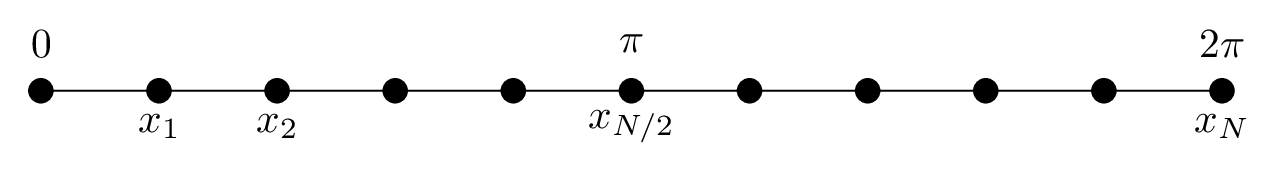

In [3]:
%%tikz --scale=1
\draw (0,0) -- (10,0);
\foreach \i in {0,1,...,10}{
    \draw [fill=black] (\i,0) circle (0.1);
};
\node at (0,0.4) {$0$};
\node at (1,-0.3) {$x_1$};
\node at (2,-0.3) {$x_2$};
\node at (5,0.4) {$\pi$};
\node at (5,-0.3) {$x_{N/2}$};
\node at (10,-0.3) {$x_{N}$};
\node at (10,0.4) {$2\pi$};

Intervals of length other than $2\pi$ are easily handled by a scale factor and translations to other intervals such as $\left[-\pi,\pi\right]$ make no difference at all. When we talk about a periodic grid, we mean that any data values on the grid come from evaluating a periodic function. Equivalently, we may regard the periodic grid as one cycle of length $N$ extracted from an infinite grid with data satisfying $v_{j+mN} = v_j$ for all $j,m \in \Zb$.

Throughout the book, the number of grid points on a periodic grid will always be even. All our results have analogues for odd $N$, but the formulas are slightly different, and little would be gained by writing everything twice. The spacing of the grid points is $h=\dfrac{2\pi}N$, which gives us

$$\dfrac{\pi}h = \dfrac{N}2$$

We recommend the reader memorize this equation. The quotient $\pi/h$ will appear over and over, since $\left[-\dfrac{\pi}h, \dfrac{\pi}h\right]$ is the range of wavenumbers distinguishable on the grid. We will make constant use of the above equation.

Let us consider the Fourier transform on the $N$-point grid. As in the last chapter, the mesh spacing $h$ implies that wavenumbers differing by an integer multiple of $2\pi/h$ are indistinguishable on the grid, and thus it will be enough to confine our attention to $k \in \left[-\pi/h,\pi/h\right]$. Now, however, the Fourier domain is discrete as well as bounded. This is because waves in physical space must be periodic over the interval $[0,2\pi]$, and only waves $e^{ikx}$ with integer wavenumbers have the required period $2\pi$. We find:

\begin{align*}
\text{Physical space} & : & \text{discrete}, & \text{bounded} & : & x \in \{h,2h,\ldots,2\pi-h,2\pi\}\\
\text{Fourier space} & : & \text{bounded}, & \text{discrete} & : & k \in \{-\dfrac{N}2+1,-\dfrac{N}2+2,\ldots, \dfrac{N}2\}
\end{align*}

The formula for the *discrete Fourier Transform (DFT)* is

$$\hat{v}_k = h \dsum_{j=1}^N e^{-ikx_j} v_j, \,\,\,\, \forall k \in \left\{-\dfrac{N}2+1, -\dfrac{N}2+2, \ldots, \dfrac{N}2\right\}$$

and the *inverse Fourier transform* is given by

$$v_j = \dfrac1{2\pi} \dsum_{-N/2+1}^{N/2} e^{ikx_j} \hat{v}_k, \,\,\,\, \forall j \in \{1,2,\ldots,N\}$$

These formulas may be compared with the Formulas from the previous chapter for Fourier transform and its inverse and the semi-discrete Fourier transform and its inverse.

In the formulas above, we see that the wavenumber $k$, like the spatial index $j$, takes only integer values. Nothing continuous or infinite is left in the problem, and we can easily check that the above two are inverses of one another for arbitrary vectors $\bkt{v_1,v_2,\ldots,v_N}^T \in \Rb^N$ or $\Cb^N$, without *any technical restrictions*.

For spectral differentiation of a grid function $v$, we follow the model of the last chapter exactly. First we need a band-limited interpolant of $v$, which we obtain by evaluating the inverse discrete Fourier transform for all $x$ rather than just on the grid. But before we differentiate our interpolant, there is a complication to address. Consider the saw-toothed function at the grid points $jh$, where $j \in \{1,2,\ldots,N\}$, such that $Nh=2\pi$, i.e., the function is defined as $v_j = (-1)^j$. We get the Fourier transform as

\begin{align*}
\hat{v}_k & = h \dsum_{j=1}^N e^{-ikx_j} \bkt{-1}^j\\
&= h\bkt{e^{-2ikh}+e^{-4ikh}+\cdots+e^{-Nikh}} - h\bkt{e^{-ikh}+e^{-3ikh}+\cdots+e^{-(N-1)ikh}}\\
& = h\bkt{e^{-2ikh}-e^{-ikh}} \bkt{1+e^{-2ikh}+e^{-4ikh}+\cdots+e^{-(N-2)ikh}}
\end{align*}

We see that

\begin{align*}
\hat{v}_k = \begin{cases}
0 & \text{ if }k \in \{-N/2+1,-N/2+2,\ldots,N/2-1\}\\
hN = 2\pi & \text{ if }k=N/2
\end{cases}
\end{align*}

This gives us
\begin{align*}
v(x) = e^{iNx/2}
\end{align*}

whose derivative is $v'(x) = iN/2 e^{iNx/2}$. We see that the interpolant and its derivative are a complex valued function! The problem is that the highest wave number is treated asymetrically. We can fix this by defining
$$\hat{v}_{-N/2} = \hat{v}_{N/2}$$
and defining

$$v_j = \dfrac1{2\pi}\tilde{\dsum}_{k=-N/2}^{N/2} e^{ikx_j} \hat{v}_k$$

where the prime indicates that the terms $k=\pm N/2$ are multiplied by $1/2$. Note that the discrete Fourier transform and its inverse can still be defined. But the above equation is needed just for the purpose of deriving a band-limited interpolant, which takes the form

$$p(x) = \dfrac1{2\pi} \tilde{\dsum}_{-N/2}^{N/2} e^{ikx} \hat{v}_k, \,\,\,\, \forall x \in [-\pi/h,\pi/h]$$

and the sawtooth now has derivative zero as it should. 

In [4]:
import pylab as pl
import scipy as sp
pi = sp.pi;
n = 1000;
from ipywidgets import interact
xp = sp.linspace(0, 2*pi, n)
@interact
def plot_periodic_sinc(N=(4, 16, 2)):
    h = 2*pi/N;
    yp = sp.cos(pi*xp/h);
    xg = sp.linspace(0,2*pi,N+1);
    yg = sp.cos(pi*xg/h);
    pl.plot(xp, yp);
    pl.plot(xg, yg,'ro');
    pl.show();

A Jupyter Widget

Note that $p(x)$ is a *trigonometric polynomial* of degree at most $N/2$. This means that it can be written as a linear combination of the functions $1, \sin(x), \cos(x), \sin(2x), \cos(2x),\ldots,\sin(Nx/2), \cos(Nx/2)$. (Actually, the $\sin(Nx/2)$ term is not needed.)

To interpolate a grid function $v$, as in the previous chapter, we can use this general formula, or we can compute the band-limited interpolant of the delta function and expand $v$ as a linear combination of translated delta functions. The delta function is now periodic.

\begin{align*}
\delta_j = \begin{cases}
1 & j \equiv 0 \pmod{N}\\
0 & j \not\equiv 0 \pmod{N}
\end{cases}
\end{align*}

We get that $\hat{\delta}_k = h$ for each $k$. Hence, we get the interpolant for the $\delta$ function to be

\begin{align*}
p(x) & = \dfrac{h}{2\pi} \bkt{\dfrac{e^{iNx/2}+e^{-iNx/2}}2 + \dsum_{k=-N/2+1}^{N/2-1} e^{ikx}}\\
& = \dfrac{\sin\bkt{\pi x/h}}{\bkt{2\pi/h} \tan\bkt{x/2}}
\end{align*}

Hence, we see that the band-limited interpolant to $\delta$ is the *periodic sinc function* $S_N$, i.e.,

$$S_N(x) = \dfrac{\sin\bkt{\pi x/h}}{\bkt{2\pi/h} \tan\bkt{x/2}}$$

Note that for $x \to 0$, we have $\tan(x/2) \sim x/2$, and hence $S_N(x)$ behaves like the non-periodic sinc function $S_h(x)$ in the limit as $x \to 0$ independently of $h$.